In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
import sys

# Mnist and Mnist-Fashion dataset

In [5]:
# MNIST
from sklearn import datasets
digits = datasets.load_digits()
X_train = digits['data']
y_train = digits['target']

In [5]:
sys.path.insert(0, "../research/fashion-mnist/")

In [6]:
from utils import mnist_reader
X_train, y_train = mnist_reader.load_mnist('../research/fashion-mnist/data/fashion', kind='train')
# X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [10]:
N = -1

(array([178., 182., 177., 183., 181., 182., 181., 179., 173., 180.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

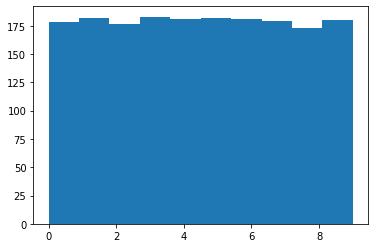

In [50]:
plt.hist(y_train[:N])

# default tsne

In [23]:
from openTSNE import TSNE, TSNEEmbedding, affinity, initialization
# from openTSNE import initialization
# from openTSNE.callbacks import ErrorLogger

In [33]:
res_tsne_def = []

tsne = TSNE(n_jobs=8,
            initialization='pca',
            callbacks=lambda it, err, emb: res_tsne_def.append((it, err)),
            callbacks_every_iters=1,
           )

In [34]:
%time embd_tsne = tsne.fit(X_train[:N])

/home/antoine/anaconda3/envs/raviz_hybrid/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/raviz_hybrid/lib/python3.7/site-packages/pynndescent/pynndescent_.py", line 38:
    @numba.njit(parallel=True, fastmath=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  self.func_ir.loc))
/home/antoine/anaconda3/envs/raviz_hybrid/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

F

CPU times: user 5min 37s, sys: 20.3 s, total: 5min 57s
Wall time: 48.7 s


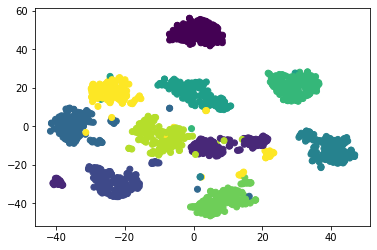

In [35]:
fig, ax = plt.subplots()
ax.scatter(embd_tsne[:,0], embd_tsne[:,1], c=y_train[:N], rasterized=True)

In [36]:
res_tsne_def = np.array(res_tsne_def)

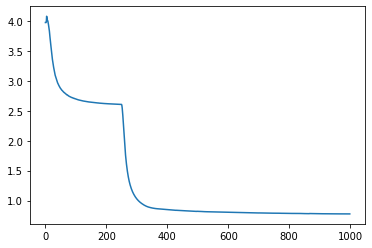

In [37]:
plt.plot(res_tsne_def[:,1])

In [47]:
res_tsne_def[-1]

array([750.        ,   0.77743842])

# PCA init

In [24]:
%time init_pca = initialization.pca(X_train, random_state=42)

CPU times: user 28.8 ms, sys: 4.36 ms, total: 33.1 ms
Wall time: 9.24 ms


# default forceatlas2

In [13]:
from openTSNE import affinity

In [14]:
affinities = affinity.PerplexityBasedNN(X_train)

/home/antoine/anaconda3/envs/raviz_hybrid/lib/python3.7/site-packages/pynndescent/pynndescent_.py:199: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/raviz_hybrid/lib/python3.7/site-packages/pynndescent/utils.py", line 459:
@numba.njit(parallel=True)
def new_build_candidates(
^

  seed_per_row,
/home/antoine/anaconda3/envs/raviz_hybrid/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/raviz_hybrid/lib/python3.7/site-packages/pynndes

In [16]:
affinities.P

<1797x1797 sparse matrix of type '<class 'numpy.float64'>'
	with 203906 stored elements in Compressed Sparse Row format>

In [17]:
import networkx as nx
from fa2 import ForceAtlas2

In [18]:
# Create ForceAtlas2 object with desired parameters
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)

In [25]:
# run forceatlas2
positions = forceatlas2.forceatlas2(affinities.P, pos=init_pca, iterations=1000)

100%|██████████| 1000/1000 [00:18<00:00, 55.26it/s]

BarnesHut Approximation  took  9.29  seconds
Repulsion forces  took  6.64  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  1.41  seconds
AdjustSpeedAndApplyForces step  took  0.32  seconds


In [26]:
positions = np.array(positions)

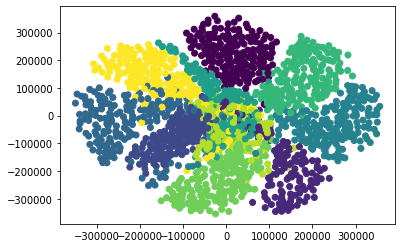

In [27]:
fig, ax = plt.subplots()
ax.scatter(positions[:,0], positions[:,1], c=y_train, rasterized=True)

In [40]:
positions

array([[ -41092.20640157,  249539.28013501],
       [ 182197.90087826, -266942.46312984],
       [  47208.06810135,  -45109.68522182],
       ...,
       [  93640.42815886,  -44201.02619119],
       [ -64637.42516091,   93665.12704339],
       [  17591.3991254 ,   31430.75382249]])

# TSNE with force init

In [41]:
from sklearn import preprocessing
init_force = preprocessing.scale(positions)

In [58]:
res_tsne_force = []

embedding = TSNEEmbedding(
    init_force,
    affinities,
    n_jobs=8,
    
    callbacks=lambda it, err, emb: res_tsne_force.append((it, err)),
    callbacks_every_iters=1,
)

In [59]:
%%time

# emb_1 = embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5)
emb_2 = embedding.optimize(n_iter=750, exaggeration=1, momentum=0.8)

CPU times: user 5min 50s, sys: 21.7 s, total: 6min 11s
Wall time: 47.9 s


In [60]:
res_tsne_force = np.array(res_tsne_force)

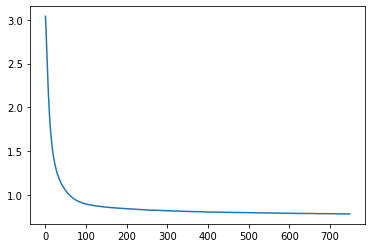

In [61]:
plt.plot(res_tsne_force[:,1])

In [62]:
res_tsne_force[-1]

array([750.        ,   0.78122363])

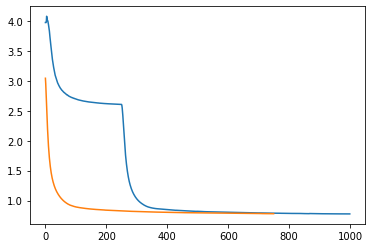

In [63]:
plt.plot(res_tsne_def[:,1])
plt.plot(res_tsne_force[:,1])

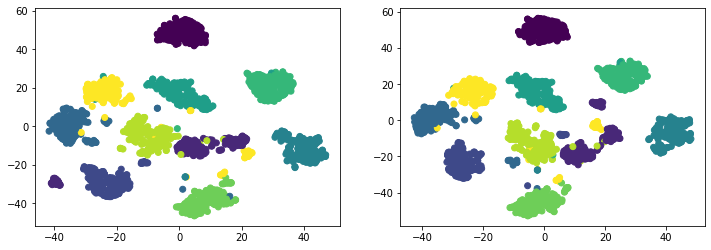

In [64]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(embd_tsne[:,0], embd_tsne[:,1], c=y_train[:N], rasterized=True)
ax[1].scatter(emb_2[:,0], emb_2[:,1], c=y_train, rasterized=True)

# KNN classification

In [65]:
import k_nn_classifier

In [66]:
k_nn_classifier.K_NN_classifier(embd_tsne, y_train)

0.9888641425389755

In [67]:
k_nn_classifier.K_NN_classifier(emb_2, y_train)

0.9866666666666667

# default force

In [17]:
import forcelayout as fl

In [19]:
from forcelayout import draw_spring_layout, distance
from forcelayout import NeighbourSampling

In [41]:
%%time

layout_chalmers = fl.NeighbourSampling(X_train[:N],
                                      )
layout_chalmers.spring_layout()

CPU times: user 2min 43s, sys: 23.7 ms, total: 2min 43s
Wall time: 2min 42s


array([[-4.00024380e+19, -3.21565531e+20],
       [-6.99857082e+19, -5.53970620e+20],
       [ 9.42797449e+18,  7.51442188e+19],
       ...,
       [ 8.24013442e+19,  6.58056431e+20],
       [-6.57635551e+19, -5.23224864e+20],
       [-2.05851059e+20, -1.63487306e+21]])

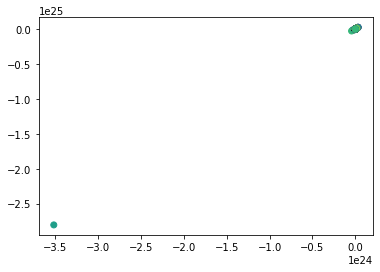

In [42]:
embedding_chalmers = layout_chalmers.get_positions()

fig, ax = plt.subplots()
ax.scatter(embedding_chalmers[:,0], embedding_chalmers[:,1], c=y_train[:N], rasterized=True)

# default pivot

In [43]:
%%time
pivot_layout = fl.Pivot(X_train[:N], 
                        sample_layout_iterations = 200,
                        remainder_layout_iterations = 100,
                        refine_layout_iterations = 5,
                        )
pivot_layout.spring_layout()

CPU times: user 4min 11s, sys: 1.36 s, total: 4min 12s
Wall time: 4min 11s


array([[  4425.0824886 ,   4755.27400839],
       [ 12067.82620829,  -4233.31198125],
       [  5954.02711548,  10729.81800238],
       ...,
       [-15125.2083806 ,   1219.10936844],
       [  3457.08338763,  -1799.449877  ],
       [  8203.62597335, -32403.19637269]])

In [44]:
pivot_layout_pos = pivot_layout.get_positions()

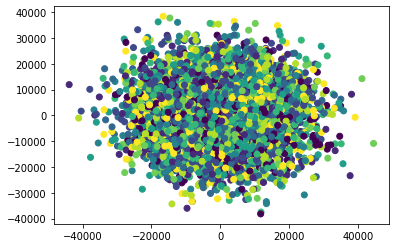

In [45]:
fig, ax = plt.subplots()
ax.scatter(pivot_layout_pos[:,0], pivot_layout_pos[:,1], c=y_train[:N], rasterized=True)

# hybrid force - tnse

In [47]:
layout_test = fl.NeighbourSampling(X_train[:N])

In [ ]:
layout_test

In [ ]:
from forcelayout.forcelayout import 